In [63]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

In [64]:
def load_dataset():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train.reshape(-1, 28 * 28) / 255.0
    x_test = x_test.reshape(-1, 28 * 28) / 255.0

    y_train_oh = np.zeros((len(y_train), 10), dtype=np.float32)
    y_train_oh[np.arange(len(y_train)), y_train] = 1.0

    y_test_oh = np.zeros((len(y_test), 10), dtype=np.float32)
    y_test_oh[np.arange(len(y_test)), y_test] = 1.0

    return x_train, y_train_oh, x_test, y_test_oh, y_test

In [65]:
class Tensor:
    def __init__(self, data, requires_grad=False, creator=None):
        self.data = data.astype(np.float32)
        self.requires_grad = requires_grad
        self.creator = creator
        self.grad = None
        self.input = None

    def backward(self, grad=None):
        if not self.requires_grad:
            return

        if grad is None and self.data.size == 1:
            grad = np.ones_like(self.data)

        self.grad = grad

        if self.creator:
            grad_input = self.creator.backward(self.grad)
            input_tensor = self.creator.input
            if input_tensor.requires_grad:
                input_tensor.backward(grad_input)

    def zero_grad(self):
        self.grad = None


In [66]:
class Parameter(Tensor):
    def __init__(self, data):
        super().__init__(data, requires_grad=True)


class Parameters:
    def __init__(self):
        self.params = []

    def add(self, param):
        if isinstance(param, Tensor) and param.requires_grad:
            self.params.append(param)

    def get(self):
        return self.params

    def zero_grad(self):
        for p in self.params:
            p.zero_grad()

    def step(self, lr):
        for p in self.params:
            if p.grad is not None:
                p.data -= lr * p.grad

In [67]:
class Linear:
    def __init__(self, in_features, out_features, params: Parameters):
        self.weight = Parameter(np.random.uniform(-1.0, 1.0, (in_features, out_features)).astype(np.float32))
        self.bias = Parameter(np.zeros(out_features, dtype=np.float32))
        self.input = None

        params.add(self.weight)
        params.add(self.bias)

    def __call__(self, x: Tensor):
        return self.forward(x)

    def forward(self, x: Tensor):
        self.input = x
        out = x.data @ self.weight.data + self.bias.data
        return Tensor(out, requires_grad=True, creator=self)

    def backward(self, grad_output):
        x = self.input

        if self.weight.requires_grad:
            self.weight.grad = x.data.T @ grad_output

        if self.bias.requires_grad:
            self.bias.grad = np.sum(grad_output, axis=0)

        return grad_output @ self.weight.data.T

In [68]:
class ReLU:
    def __init__(self):
        self.input = None

    def __call__(self, x: Tensor):
        return self.forward(x)

    def forward(self, x: Tensor):
        self.input = x
        out = np.maximum(0, x.data)
        return Tensor(out, requires_grad=True, creator=self)

    def backward(self, grad_output):
        return grad_output * (self.input.data > 0).astype(np.float32)

In [69]:
class BatchNorm:
    def __init__(self, dim, momentum=0.9, eps=1e-5, params: Parameters = None):
        self.gamma = Parameter(np.ones(dim, dtype=np.float32))
        self.beta = Parameter(np.zeros(dim, dtype=np.float32))

        if params:
            params.add(self.gamma)
            params.add(self.beta)

        self.running_mean = np.zeros(dim, dtype=np.float32)
        self.running_var = np.ones(dim, dtype=np.float32)

        self.eps = eps
        self.momentum = momentum
        self.training = True

        self.input = None
        self.x_hat = None

    def __call__(self, x: Tensor, training=True):
        return self.forward(x, training)

    def forward(self, x: Tensor, training=True):
        self.input = x
        self.training = training

        if training:
            mean = x.data.mean(axis=0)
            var = x.data.var(axis=0)
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * mean
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * var
        else:
            mean = self.running_mean
            var = self.running_var

        self.x_hat = (x.data - mean) / np.sqrt(var + self.eps)
        out = self.gamma.data * self.x_hat + self.beta.data
        return Tensor(out, requires_grad=True, creator=self)

    def backward(self, grad_output):
        x = self.input
        N = x.data.shape[0]

        dx_hat = grad_output * self.gamma.data
        var = x.data.var(axis=0)
        std_inv = 1.0 / np.sqrt(var + self.eps)

        dvar = np.sum(dx_hat * (x.data - x.data.mean(axis=0)) * -0.5 * std_inv**3, axis=0)
        dmean = np.sum(dx_hat * -std_inv, axis=0) + dvar * np.mean(-2.0 * (x.data - x.data.mean(axis=0)), axis=0)

        dx = dx_hat * std_inv + dvar * 2 * (x.data - x.data.mean(axis=0)) / N + dmean / N

        self.gamma.grad = np.sum(grad_output * self.x_hat, axis=0)
        self.beta.grad = np.sum(grad_output, axis=0)

        return dx

In [70]:
class SoftmaxCrossEntropy:
    def __init__(self):
        self.softmax = None
        self.targets = None
        self.input = None

    def __call__(self, logits: Tensor, targets: np.ndarray):
        return self.forward(logits, targets)

    def forward(self, logits: Tensor, targets: np.ndarray):
        self.input = logits
        self.targets = targets

        exps = np.exp(logits.data - np.max(logits.data, axis=1, keepdims=True))
        self.softmax = exps / np.sum(exps, axis=1, keepdims=True)

        N = logits.data.shape[0]
        correct_logprobs = -np.log(self.softmax[np.arange(N), np.argmax(targets, axis=1)] + 1e-12)
        loss = np.mean(correct_logprobs)

        return Tensor(loss, requires_grad=True, creator=self)

    def backward(self, grad_output):
        N = self.softmax.shape[0]
        grad = (self.softmax - self.targets) / N
        return grad

In [71]:
class MLP:
    def __init__(self):
        self.params = Parameters()

        self.fc1 = Linear(784, 256, self.params)
        self.bn1 = BatchNorm(256, params=self.params)
        self.relu1 = ReLU()

        self.fc2 = Linear(256, 128, self.params)
        self.bn2 = BatchNorm(128, params=self.params)
        self.relu2 = ReLU()

        self.fc3 = Linear(128, 10, self.params)

    def __call__(self, x: Tensor, training=True):
        x = self.fc1(x)
        x = self.bn1(x, training=training)
        x = self.relu1(x)

        x = self.fc2(x)
        x = self.bn2(x, training=training)
        x = self.relu2(x)

        x = self.fc3(x)
        return x

    def parameters(self):
        return self.params.get()

    def save_weights(self, path):
        weights = {f'param_{i}': p.data for i, p in enumerate(self.params.get())}
        np.savez(path, **weights)

    def load_weights(self, path):
        data = np.load(path)
        for i, p in enumerate(self.params.get()):
            p.data = data[f'param_{i}']

In [72]:
class SGD:
    def __init__(self, parameters: Parameters, lr=0.1):
        self.parameters = parameters
        self.lr = lr

    def step(self):
        self.parameters.step(self.lr)

    def zero_grad(self):
        self.parameters.zero_grad()

In [73]:
def train(model, optimizer, loss_fn, x_train, y_train, x_test, y_test, epochs=10, batch_size=64):
    loss_history = []
    acc_history = []
    test_loss_history = []

    for epoch in range(epochs):
        perm = np.random.permutation(x_train.shape[0])
        x_train = x_train[perm]
        y_train = y_train[perm]

        epoch_loss = 0.0
        for i in range(0, x_train.shape[0], batch_size):
            x_batch = x_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]

            x_tensor = Tensor(x_batch, requires_grad=True)
            probs = model(x_tensor, training=True)
            loss = loss_fn(probs, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.data

        avg_loss = epoch_loss / (x_train.shape[0] // batch_size)
        loss_history.append(avg_loss)

        x_test_tensor = Tensor(x_test, requires_grad=False)
        preds = model(x_test_tensor, training=False)
        test_loss = loss_fn(preds, y_test).data
        test_loss_history.append(test_loss)

        acc = (np.argmax(preds.data, axis=1) == np.argmax(y_test, axis=1)).mean()
        acc_history.append(acc)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {acc:.4f}")

    model.save_weights('best_weights.npz')

    return loss_history, test_loss_history, acc_history


Epoch 1/10 | Train Loss: 0.7536 | Test Loss: 0.3619 | Test Acc: 0.8906
Epoch 2/10 | Train Loss: 0.3525 | Test Loss: 0.2817 | Test Acc: 0.9130
Epoch 3/10 | Train Loss: 0.2858 | Test Loss: 0.2444 | Test Acc: 0.9244
Epoch 4/10 | Train Loss: 0.2488 | Test Loss: 0.2245 | Test Acc: 0.9313
Epoch 5/10 | Train Loss: 0.2258 | Test Loss: 0.2038 | Test Acc: 0.9381
Epoch 6/10 | Train Loss: 0.2078 | Test Loss: 0.1937 | Test Acc: 0.9407
Epoch 7/10 | Train Loss: 0.1914 | Test Loss: 0.1800 | Test Acc: 0.9458
Epoch 8/10 | Train Loss: 0.1789 | Test Loss: 0.1719 | Test Acc: 0.9484
Epoch 9/10 | Train Loss: 0.1665 | Test Loss: 0.1644 | Test Acc: 0.9502
Epoch 10/10 | Train Loss: 0.1610 | Test Loss: 0.1590 | Test Acc: 0.9539


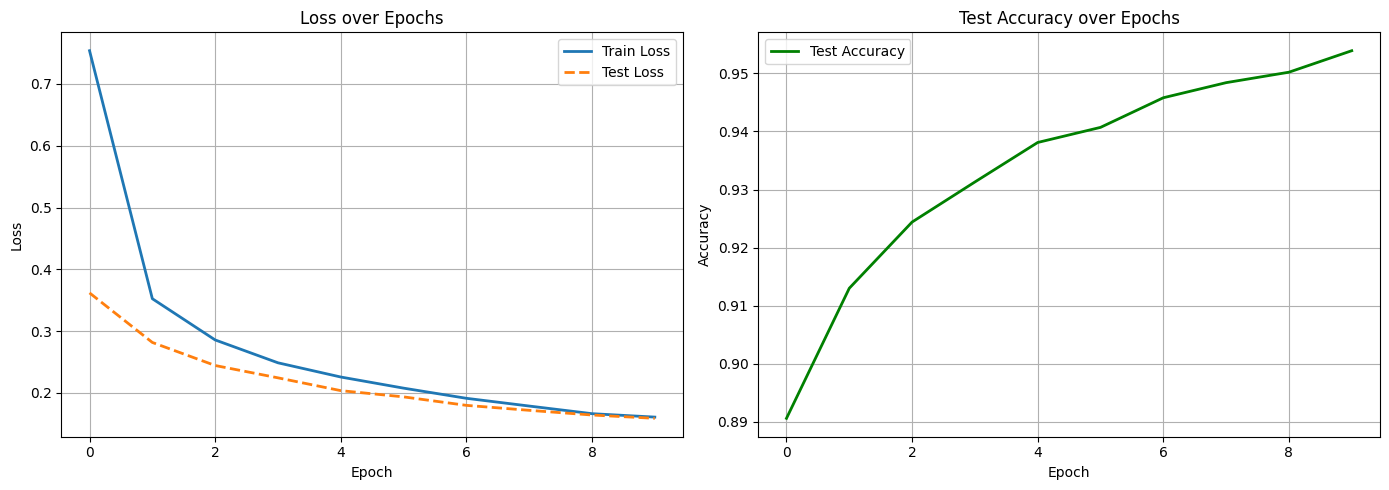

In [74]:
x_train, y_train_oh, x_test, y_test_oh, y_test = load_dataset()

model = MLP()
optimizer = SGD(model.params, lr=0.1)
loss_fn = SoftmaxCrossEntropy()

loss_history, test_loss_history, acc_history = train(
    model, optimizer, loss_fn, x_train, y_train_oh, x_test, y_test_oh,
    epochs=10, batch_size=64
)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_history, label="Train Loss", linewidth=2)
plt.plot(test_loss_history, label="Test Loss", linewidth=2, linestyle='--')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(acc_history, label="Test Accuracy", color='green', linewidth=2)
plt.title("Test Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

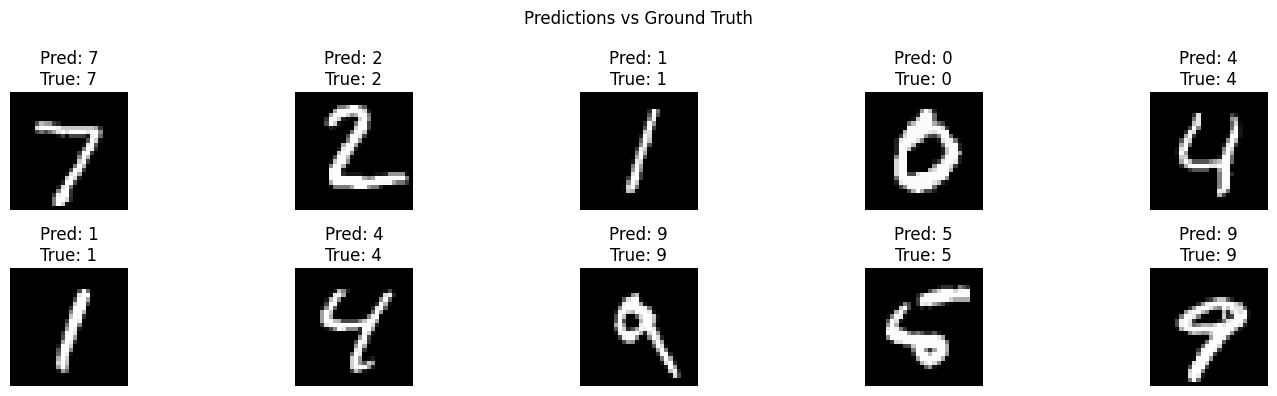

In [75]:
logits = model(Tensor(x_test), training=False)
predictions = np.argmax(logits.data, axis=1)

plt.figure(figsize=(15, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title(f"Pred: {predictions[i]}\nTrue: {y_test[i]}")
    plt.axis('off')

plt.suptitle("Predictions vs Ground Truth")
plt.tight_layout()
plt.show()